In [213]:
# -*- coding: utf_8 -*-  
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

import copy
import json
import pandas as pd
import numpy as np
import datetime
import math
import time

import sklearn.linear_model


from keras.models import Model, Sequential
from keras.layers import Dense, Activation, recurrent, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
import keras.layers.merge

from scipy import signal
from scipy import stats


import pickle
import sys
import random
import h5py

        
def makeRNN_dual(input_cs, output_cs,dropout=0.5):
    #rnn1 = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
    rnn_f = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=False,dropout=dropout, recurrent_regularizer='l1', kernel_regularizer='l2') #forward
    rnn_b = recurrent.SimpleRNN(units=output_cs, activation='linear', input_shape=(None, input_cs),return_sequences=False,dropout=dropout, recurrent_regularizer='l1', kernel_regularizer='l2') #backward
    input_f = Input(shape=(None,input_cs), dtype='float32', name='input_f')
    input_b = Input(shape=(None,input_cs), dtype='float32', name='input_b')
    rnn_f_o = rnn_f(input_f)
    rnn_b_o = rnn_b(input_b)
    out = keras.layers.merge([rnn_f_o, rnn_b_o], mode='sum')
    model = Model(input=[input_f, input_b], output=out)
    #model = Model(input=[input_f], output=rnn_f_o)
    model.compile(optimizer='adadelta',
                  loss='mse',
                  metrics=['mse','cosine_proximity'])
    return model

In [234]:
test=h5py.File('Ma/DeepANES.mat')

ECoG = np.array(test['ECoG'])
EEG = np.array(test['EEG'])
EEG = np.delete(EEG, 14, axis=1)
EEG = EEG.astype('float32')
ECoG = ECoG.astype('float32')

ff = 2/1000
b, a = signal.butter(4, [0.1*ff, 200*ff], btype='bandpass')
b_n, a_n, = signal.iirnotch(50*ff, 10)

samples = 9
# timesteps = 1024 だめだった
# timesteps = 8192 まぁまぁできた
timesteps = 1024*5
start= timesteps*1

def make_timeStepData(data, samples,timesteps=4096, start=0):
    out1 = np.zeros((timesteps, samples, data.shape[1]))
    out2 = np.zeros((timesteps, samples, data.shape[1]))
    for t in range(samples):
        t0 = t+start
        t1 = t0+timesteps
        for ch in range(data.shape[1]):
            out1[:,t,ch] = data[t0:t1,ch]
            out2[:,t,ch] = data[t1:t0:-1, ch]
    return out1, out2

def do_filter(b,a,data):
    out = np.zeros(data.shape)
    for ch in range(data.shape[1]):
        out[:,ch] = signal.filtfilt(b, a, data[:,ch])
    return out


In [235]:
EEG_f = do_filter(b_n, a_n, do_filter(b, a, EEG))
ECoG_f = do_filter(b_n, a_n, do_filter(b, a, ECoG))
#EEG_f = do_filter(b_n, a_n, EEG)
#ECoG_f = do_filter(b_n, a_n, ECoG)


ECoG1, ECoG2 = make_timeStepData(ECoG_f, samples, timesteps, start)
EEG1, EEG2 = make_timeStepData(EEG_f, samples, timesteps, start)

In [236]:
model = makeRNN_dual(16, 256,dropout=0.125)

/usr/local/pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:41: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("me...)`


In [237]:
ECoG_p = ECoG_f[start:start+timesteps, :]
loss = model.fit([EEG1,EEG2], ECoG_p, epochs=2000, verbose=0)

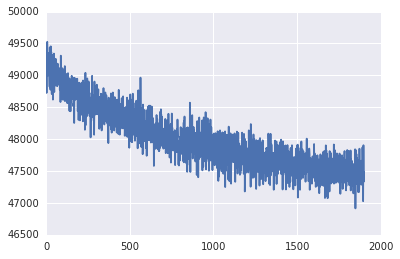

In [238]:
plt.plot(loss.history['mean_squared_error'][100:])

In [239]:
ECoG_pre = model.predict([EEG1,EEG2])
out = []
for ch in range(256):
    out.append(np.corrcoef(ECoG_p[:, ch], ECoG_pre[:, ch])[0, 1])
out = np.array(out)
print(out.mean())

0.766851896135


In [240]:
# LR
EEG_tr = EEG_f[start:start+timesteps, :]
out_lr = []
model_lrs = []
for ch in range(256):
    model_lr = sklearn.linear_model.LinearRegression()
    model_lr.fit(EEG_tr, ECoG_p[:, ch])
    model_lrs.append(model_lr)
    pp = model_lr.predict(EEG_tr)
    out_lr.append(np.corrcoef(pp, ECoG_p[:, ch])[0, 1])
out_lr = np.array(out_lr)
print(out_lr.mean())

0.708002031457


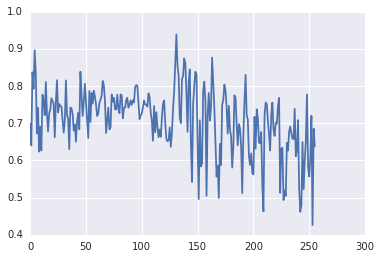

In [241]:
plt.plot(out_lr)

In [242]:
outout = []
outout_p = []
outout_lr = []
outout_lr_p = []
for n in range(int(ECoG.shape[0]/timesteps)):
    start= timesteps*n
    ECoG1, ECoG2 = make_timeStepData(ECoG_f, samples, timesteps, start)
    EEG1, EEG2 = make_timeStepData(EEG_f, samples, timesteps, start)

    ECoG_pre = model.predict([EEG1,EEG2])
    #ECoG_pre = model.predict([EEG1, EEG2])
    EEG_tr = EEG_f[start:start+timesteps, :]
    out_lr = []
    out_lr_p = []
    out = []
    out_p = []
    for ch in range(256):
        c, p = stats.pearsonr(ECoG_p[:, ch], ECoG_pre[:, ch])
        p = p*(int(c>0)-0.5)*2
        out.append(c)
        out_p.append(p)
        pp = model_lrs[ch].predict(EEG_tr)
        c, p = stats.pearsonr(pp, ECoG_p[:, ch])
        out_lr.append(c)
        out_lr_p.append(p)
    outout.append(out)
    outout_p.append(out_p)
    outout_lr.append(out_lr)
    outout_lr_p.append(out_lr_p)
RNN_out = np.array(outout)
RNN_out_p = np.array(outout_p)
LR_out = np.array(outout_lr)
LR_out_p = np.array(outout_lr_p)

print(RNN_out.shape)
print(LR_out.shape)

(58, 256)
(58, 256)


In [243]:
np.sum((RNN_out[:,:]-LR_out[:,:]).mean(axis=0)>0)/256

0.55078125

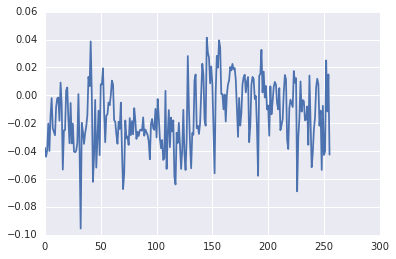

In [244]:
plt.plot(RNN_out[2:,:].mean(axis=0))

In [245]:
np.sum(RNN_out_p[2:,:]<0.01/256, axis=1).mean()

226.42857142857142

In [246]:
np.sum(LR_out_p[2:,:]<0.01/256, axis=1).mean()

194.30357142857142

In [247]:
def compare_out(out1, out2):
    out = []
    if out1.shape != out2.shape:
        print('入力が同じサイズでない')
        return
    for ch in range(out1.shape[1]):
        win = np.sum(out1[:,ch]>out2[:,ch])
        p = stats.binom_test(win, n=out1.shape[0], p=0.5, alternative='greater')
        out.append([win, p])
    return np.array(out)

In [248]:
out_biTest = compare_out(RNN_out, LR_out)

In [253]:
np.sum(out_biTest[:,1]<0.05)

37

In [254]:
256*0.05

12.8

In [251]:
len(RNN_out)

58

In [252]:
pp.shape

(5120,)

In [255]:
# RNNとLRの学習後ECoGの周波数帯域を比較（有意差あったもの）
# ECoG チャンネルの描画

In [301]:
len(np.where(out_biTest[:,1]<0.05*2)[0])

52

In [269]:
pp

array([ -86.34340716,  -50.40962038,    6.17635471, ..., -208.49570696,
       -190.32695054, -193.96661534])

In [290]:
Pxx_den_RNN.shape

(12, 37, 58)

In [294]:
Pxx_den

array([  9.40910110e+01,   6.26196777e+02,   2.39625702e+02,
         7.25581207e+01,   3.02067051e+01,   3.21350021e+01,
         2.87323589e+01,   2.61232662e+01,   2.21967354e+01,
         1.97701092e+01,   1.85534725e+01,   1.13397579e+01,
         4.79304600e+00,   1.91716850e+00,   3.22037768e+00,
         3.96012807e+00,   2.76691771e+00,   2.24265337e+00,
         1.50915587e+00,   1.34011126e+00,   1.26505804e+00,
         1.25006485e+00,   1.52881086e+00,   2.42594433e+00,
         1.77617180e+00,   2.37444973e+01,   3.27628441e+01,
         4.30530453e+00,   2.00631928e+00,   1.91301084e+00,
         1.85134518e+00,   3.01586747e+00,   2.82533240e+00,
         2.13700271e+00,   2.67532754e+00,   2.86970687e+00,
         2.75395441e+00,   4.35627365e+00,   1.55284796e+01,
         1.25224209e+01,   2.19465899e+00,   1.87924826e+00,
         1.29149497e+00,   1.62549841e+00,   1.39462519e+00,
         7.72909224e-01,   6.26308024e-01,   9.27762866e-01,
         1.11749125e+00,

In [315]:
Pxx_den_RNN.shape

(48, 19, 58)

In [322]:
chs = np.where(out_biTest[:,1]<0.01*2)[0]
T = int(ECoG.shape[0]/timesteps)
n = 20
fs=1000
Pxx_den_RNN = np.zeros((n, len(chs), T))
Pxx_den_LR = np.zeros((n, len(chs), T))

for t in range(T):
    start= timesteps*t
    EEG1, EEG2 = make_timeStepData(EEG_f, samples, timesteps, start)
    ECoG_p = model.predict([EEG1,EEG2])
    EEG_tr = EEG_f[start:start+timesteps, :]
    for i, ch in enumerate(chs):
        # RNN
        f, Pxx_den = signal.welch(ECoG_p[:, ch], fs)
        f = f[:n]
        tmp = np.log10(Pxx_den[:n])
        Pxx_den_RNN[:,i, t] = tmp#/tmp.sum()
        # LR
        pp = model_lrs[ch].predict(EEG_tr)
        f, Pxx_den = signal.welch(pp, fs)
        f = f[:n]
        tmp = np.log10(Pxx_den[:n])
        Pxx_den_LR[:,i, t] = tmp#/tmp.sum()

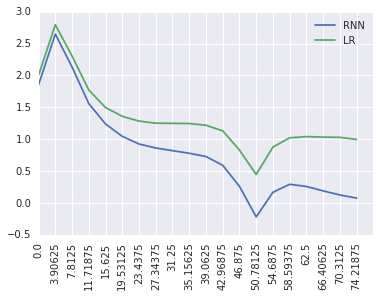

In [323]:
plt.plot(Pxx_den_RNN.mean(axis=2).mean(axis=1))
plt.plot(Pxx_den_LR.mean(axis=2).mean(axis=1))

plt.legend(['RNN', 'LR'])
plt.xticks(range(0, len(f)), f, rotation=90)
plt.show()

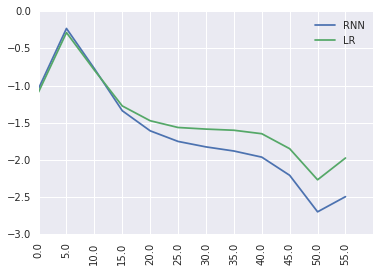

In [283]:
plt.plot(Pxx_den_RNN.mean(axis=2).mean(axis=1))
plt.plot(Pxx_den_LR.mean(axis=2).mean(axis=1))

plt.legend(['RNN', 'LR'])
plt.xticks(range(0, len(f)), f, rotation=90)
plt.show()

In [297]:
T

58

In [303]:
len(chs)

19

In [304]:
chs

array([141, 146, 157, 166, 167, 192, 206, 210, 212, 213, 215, 220, 221,
       230, 231, 232, 233, 246, 247])

In [306]:
stats.binom_test(52, 256, p=0.05, alternative='greater')

6.3667165876861465e-18

In [307]:
stats.binom_test(19, 256, p=0.01, alternative='greater')

2.4809798291669935e-11